In [ ]:
## install polyase
## conda create polyase
## conda activate polyase
## pip install -i https://test.pypi.org/simple/ polyase==0.1.2
## conda install jupyterlab
## conda install ipykernel

from polyase import *
import os
import numpy as np


#Define BASEDIR
BASEDIR = '/home/train/longTREC/day3/data/allele_expression'os.chdir(BASEDIR)

# Allele specific expression analysis practical

In the following 1h we will analyze a long-read RNA-seq potato dataset for allele specific expression. 
1) We will look at the data and how it was obtained

2) We will learn about quality control steps in allele-specific expression analysis and apply it to our data

3) We will test if there is any difference in expression between alleles within conditions (cis)

4) We will test if there is any difference in expression between alleles between conditions (trans)

## Sample info

- 10 samples of Potato cv Atlantic
- Two conditions (tubers, leaves)
- tetraploid --> 4 haplotypes

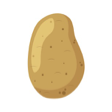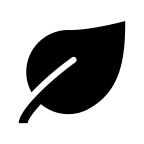

long-read RNA-seq was generated for genome annotation from this [article](https://www.sciencedirect.com/science/article/pii/S167420522200003X) by nanopore cDNA sequencing and is available on [SRA](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA718240)

## Available Files (in LongTREC/day3/data/allele_expression)
1) var_obs_file:<br>
    Gene metadata
2) gene_counts:<br>
    Allele-specific counts for genes in each haplotype and by sample
3) Bigwig files of aligned reads for vizulaization



### How did we generate the allele-specific counts?

1) Extract transcripts from phased assembly.

We mapped the reads to the CDS regions only, because we noticed that UTRs have very variable length between the same gene on different haplotypes, which is most likely a annotation problem. So to avoid bias because of this we remove the UTRs in our reference. Also we only took the longest isoform for each gene as there are many isoforms that have a bad annotation and we don't want to complicate the analysis with alleles and isoforms.

Phased transcripts from potato assembly           |  UTR length problem
:-------------------------:|:-------------------------:
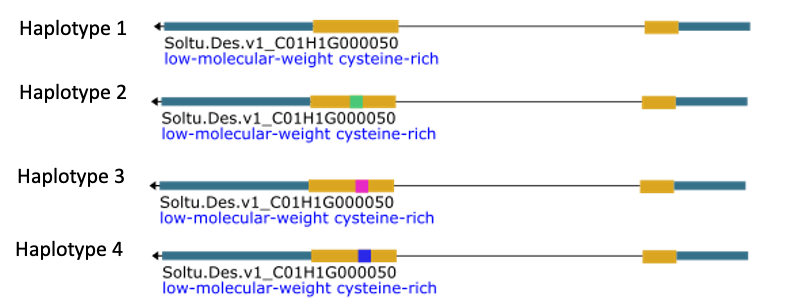 | 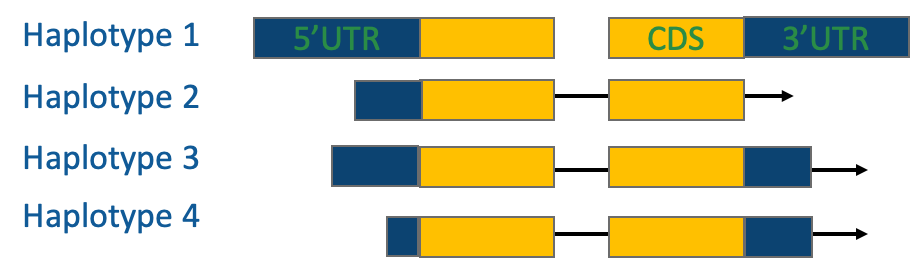


2) Map with minimap2 to transcripts <br>
We count reads mapping best to one allele and multimapping counts (e.g if there is no differnce between alleles/genes or reads are too short to differentiate alleles)

For quality control we have done a PCA based on gene-level counts. Lets look at it:
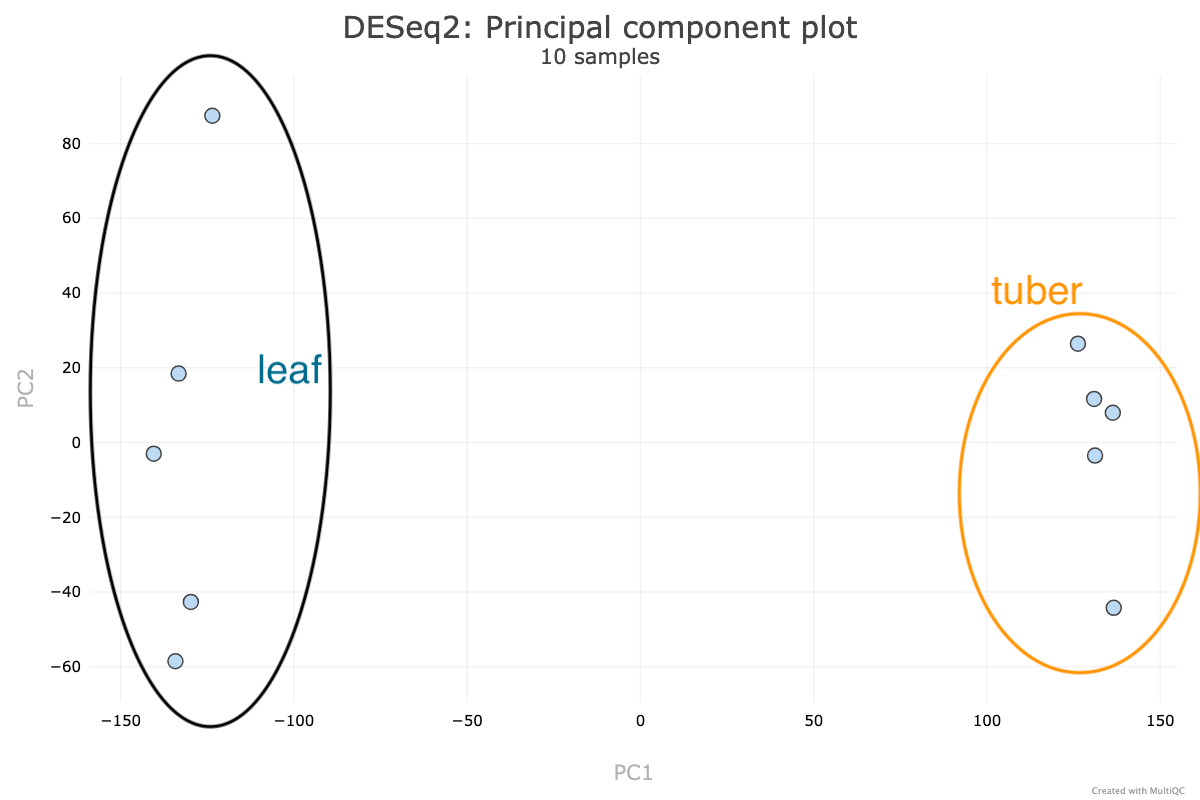

Lets take a look at the input files:
* read counts for one sample

In [ ]:
!head "{BASEDIR}/allele_counts/SRR14993892_leaf.counts.tsv"

For each transcript_id we have the number of unique counts and the number of ambigious counts (when a read maps equally well to one or more transcript_ids)

# 1) Loading the allele-specific count data 

First we load in the allele-specific counts for our 10 samples (ONT cDNA from 5 x potato tubers, 5 x potato leaves). We also have some metadata ("metadata.tsv") that links the gene ids from the alleles of a gene together with "Synt_ids" and we have some information about the allele lengths that we use for quality control.

In [ ]:
# Metadata for genes
var_obs_file = f'{BASEDIR}/metadata.tsv'
# directory of gene counts from minimap2
gene_counts_dir = f'{BASEDIR}/allele_counts'
# Define sample IDs and their conditions
sample_info = {
    "SRR14993892": "leaf",
    "SRR14993893": "leaf", 
    "SRR14993894": "leaf",
    "SRR14993895": "leaf",
    "SRR14996168": "leaf",
    "SRR14995031": "tuber",
    "SRR14995032": "tuber",
    "SRR14995033": "tuber",
    "SRR14995034": "tuber",
    "SRR14995933": "tuber",
}

# Load the data into an AnnData object
allelic_data = load_ase_data(
    var_obs_file=var_obs_file,
    gene_counts_dir=gene_counts_dir,
    sample_info=sample_info, fillna=0)

#### Task: 
look at the metadata information of each transcript id

In [ ]:
allelic_data.var.sort_values("CDS_haplotype_with_longest_annotation").head()

### Column Definitions

#### transcript_id
Unique identifier for each individual transcript.

#### Synt_id
Identifier for each gene. Multiple transcripts (alleles) that belong to the same gene share the same Synt_id.

#### synteny_category
Indicates the haplotype distribution for each gene using the format:
`{count}hap{number}_{count}hap{number}_..._{synteny_status}`

**Example:** `2hap1_2hap2_0hap3_1hap4_no_s`
- 2 copies on haplotype 1
- 2 copies on haplotype 2  
- 0 copies on haplotype 3
- 1 copy on haplotype 4
- `no_s` = non-syntenic (vs `s` = syntenic)

#### CDS_haplotype_with_longest_annotation
Identifies which haplotype contains the gene with the longest annotation length.

**Values:**
- `4G` = 4th haplotype has longest annotation
- `equal length` = multiple haplotypes have identical longest length

#### CDS_length_category
Describes the length variation between the longest and shortest alleles of the same gene.

**Examples:**
- `less_1%_difference` = minimal length variation
- `more_5%_difference` = significant length variation

#### TASK:

Look at the 'Kinase binding protein CGI-121 domain containing protein' in the [jBrowse](https://spuddb.uga.edu/jb2/?session=share-5XsMBKZFzB&password=SKUoM).

**Question**: Which synteny category would you assign it to?

#### Answer

**1hap1_1hap2_1hap3_1hap4_s** because it is once on every haplotype and has the same genes as neighbours on the haplotypes

Example for synteny_category:
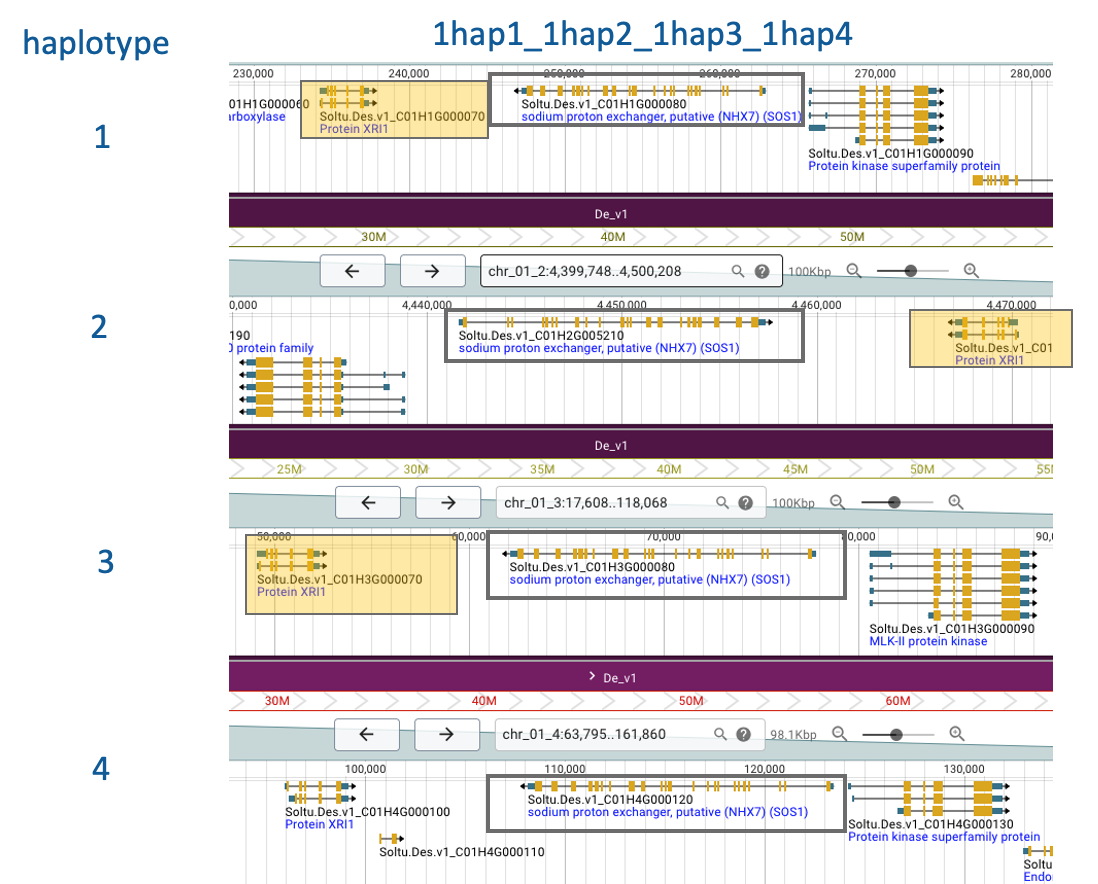

#### Look at the information of counts

In [ ]:
allelic_data.layers['unique_counts']

In [ ]:
allelic_data.layers["ambiguous_counts"]

In [ ]:
allelic_data.var_names

In [ ]:
allelic_data.obs

* rows: our 10 replicates
* columns: the transcript_ids


# 2) Quality Control
Now that we inspected the count data and metadata, we can start to do some quality control.


## Criteria for quality control

- Filter low expressed genes
- High bias towards one allele
- Multimapping ratio
- Same CDS length

### A) Filter genenes with low expression

We filter Syntelog groups that low read counts normaoized on the samples library size

In [ ]:
allelic_data = filter_low_expression(allelic_data,
                                          min_expression=20,
                                          group_col= 'Synt_id',
                                          mode= 'all') # all replicates should have min_expression)

### B) High bias towards one allele
Calculate allelic ratios to see if there are genes that have high bias (e.g > 0.6 of total counts) towards one allele.

For that we will calculate the allelic ratios simply by: allelic_ratio = allele counts/total counts for this gene.
We will use these alleic ratios to make a histogram later.

In [ ]:
allelic_data = calculate_allelic_ratios(allelic_data, 'unique_counts')


In [ ]:
allelic_data.layers["allelic_ratio_unique_counts"]

### Rows are replicates; columns are transcript ids

### C) Multimapping Ratio

For each transcript_id we have the unique counts and the multimapping/ambiguous counts. We use this to calculate the multimapping ratio for each gene/Synt_id:

**Multimapping ratio formula:**
```
Multimapping ratio = number of ambiguous counts / number of total counts (unique + ambiguous)
```

Where:
- **Unique counts:** reads that map to only one location
- **Ambiguous counts:** reads that map to multiple locations (multimapping)
- **Total counts:** sum of unique and ambiguous counts



In [ ]:
# now lets calculate the multimapping ratios for each Synt_id
allelic_data = calculate_multi_ratios(allelic_data, 'unique_counts', 'ambiguous_counts')

In [ ]:
# The multimapping information also has been added to the andata object
allelic_data.var.head()

#### Question: What does it mean to have a high multimapping ratio?

#### Answer

If two/or more alles are identical they will have all reads multimapping. Also if there a multiple copies of a gene on one halotype, reads could multimap on this haplotype

#### QC Plot

Now we can make a histogram to show the distribution of allelic ratios for the genes with low mulitmapping ratios/ ambigious counts (GREEN) and high mulitmapping ratios/ ambigious counts (GREY)

In [ ]:
plot_allelic_ratios(
    allelic_data,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.25
)

#### Task: 
Change the "multimapping_threshold" and see how the green distribution changes

### Question: 

Can you explain the differences between the green and grey distributions?

- Can you explain why most alleles with low mulitmapping ratios have 0.25 allelic ratio 
- And what is the distribution for the genes with high mulitmapping ratios

### Answers:




#### Theoretical expectation
We expect that genes with four alleles have relatively equal expression across all four alleles, resulting in a ratio of **1/4 (0.25)** per allele.

#### Impact of multimapping
For genes with high multimapping rates, the distribution becomes skewed:

- **Problem:** Some alleles have no unique counts while others receive disproportionately more
- **Example scenario:** When two alleles are identical:
  - The identical alleles cannot be distinguished by unique reads
  - The remaining two distinguishable alleles each receive approximately **50% (0.5)** of the unique counts
  - This creates a characteristic bump at **0.5** in the expression ratio histogram

This multimapping bias explains the deviation from the expected equal distribution and highlights the importance of quality control filtering.

### D) Investigation of genes with high bias towards one allele

We observe that some genes have high bias towards one allele ('allelic_ratio_unique_counts' > 0.6). We can inspect these genes to see if there are any mistakes. In the next plot we will only look at genes that have the same CDS length for all allelels and low multimapping ratios, to ensure that these factors don't cause the observed bias.

In [ ]:
high_bias = allelic_data[:,(allelic_data .var['multimapping_ratio'] < 0.25) & (allelic_data .layers['allelic_ratio_unique_counts'] > 0.6).all(axis=0) & (allelic_data .var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")]
high_bias.var.head()

Now we want to look at one of these genes with high bias in more detail. First we look at the allelic ratios to see which of the alleles has the highest expression

In [ ]:
import pandas as pd

# We will look at the allelic ratios
df = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].layers['allelic_ratio_unique_counts']
pd.DataFrame(data= df, index = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].obs.index, columns = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].var_names)

The rows are the replicates and the columns are the alleic ratios for alleles.

Which allele has the highest expression? (look at the 04_{haplotype}G of the gene id for the allele)

Lets also look at the metadata for this gene: 

In [ ]:
allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].var

Lets also look at the annotation in the [genome browser](https://spuddb.uga.edu/jb2/?session=share-Q7AqVFDKBg&password=OioEy).
Open the link and upload bigwig files provided [here]. You can upload them by clicking [Add a track] > [choose file] and then open the bigwig file
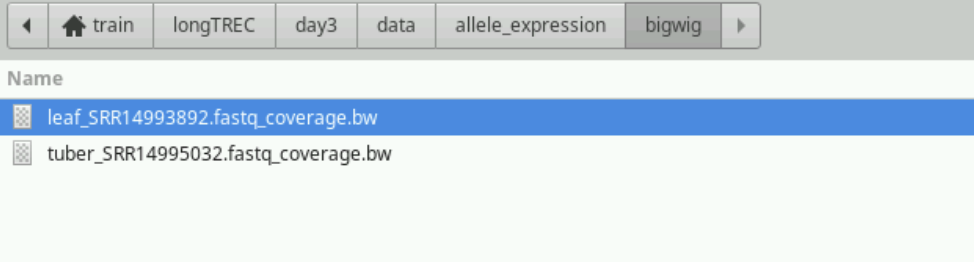



#### Questions

- Which of the alleles is the longest in the annotation? And which one with the highest allelic ratio? Do you see a connection?
- Do you think the gene annotation is correct on all haplotypes?

#### Answer

On haplotype 1 the gene seems to be correclty annotated (based on the coverate), however on the other haplotypes it's too short and annotated as two genes.
As haplotype 1 is the longest and correct annotation also the reads from the other alleles map there and we see a bias towards haplotype 1. It is important to correct these errors or remove genes like this from the downstream analysis.

### In case jBrowse does not work, expand here




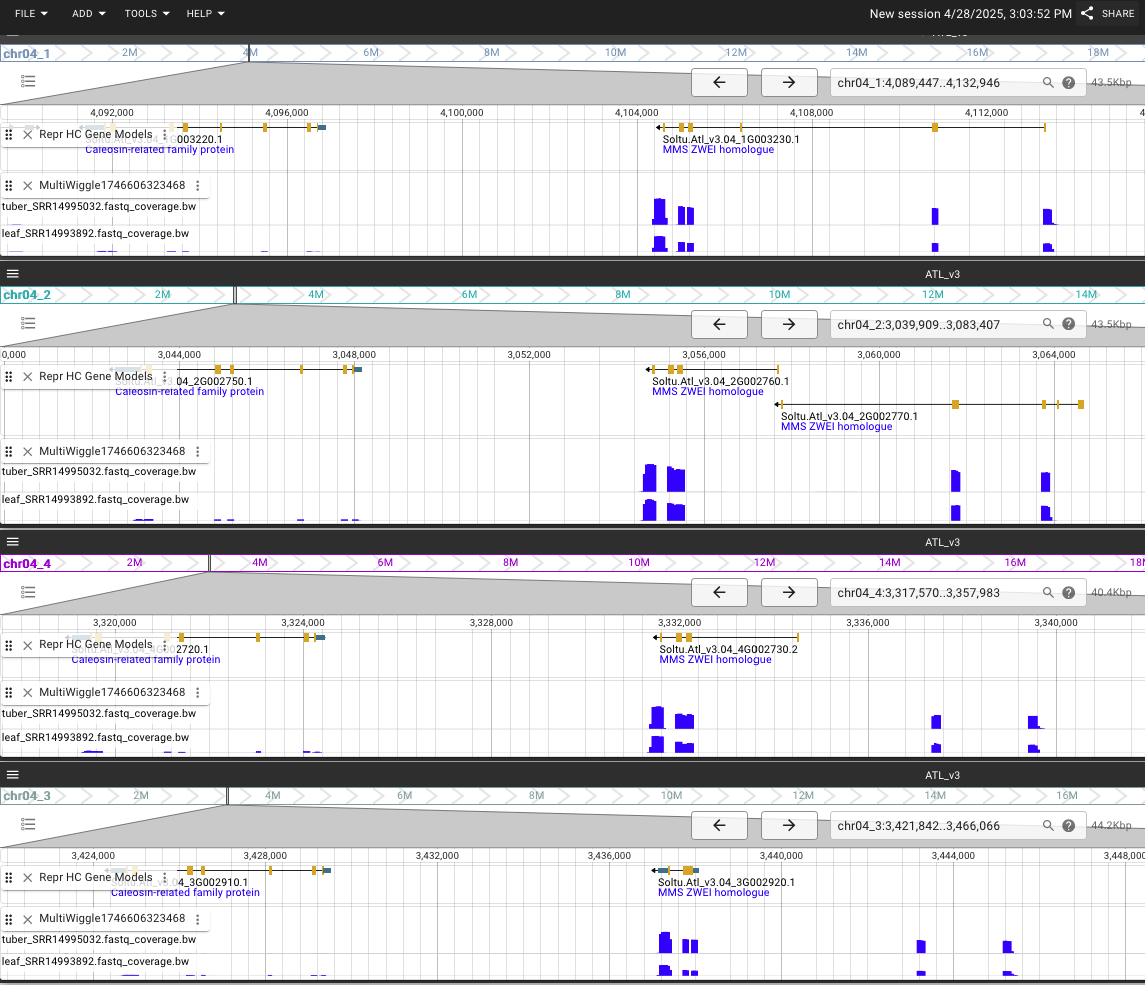

### Filter Alleles with same CDS length

To avoid annotation errors to bias the results, we will only look at alleles that have the same length on all haplotypes:

In [ ]:
# filter transcripts that are not equal lengths
mask = allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths"
allelic_data_length_filter = allelic_data[:,mask].copy()
plot_allelic_ratios(
    allelic_data_length_filter,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.25
)

Without filtering:

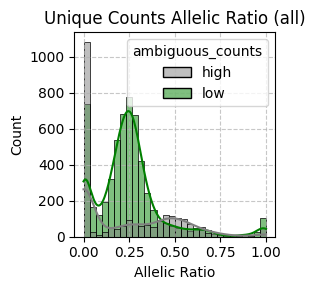

What is the difference between the length filtered results and the unfiltered ones? Do we will observe genes with high bias?

# 3) Testing for allelic imbalance

Now that we have the counts per allele and filtered genes that could be biased by high number of ambgious reads and length differences, we want to test if there are genens that have unbalanced allelic expression (> or < than 0.25).

For this we use the likelihood ratio test from [Isotools](https://isotools.readthedocs.io/en/latest/notebooks/09_diff_splice.html) to test if there is a signigicant difference between our observed allelic counts and 25% of the total counts.

Why do we only test one condition here? (not leaf and tuber at the same time)
Because between tissues we expect that there are also trans effects (different transcription factors), but within one condition only cis differences (promotors, ..) should be responsible for difference in expression. 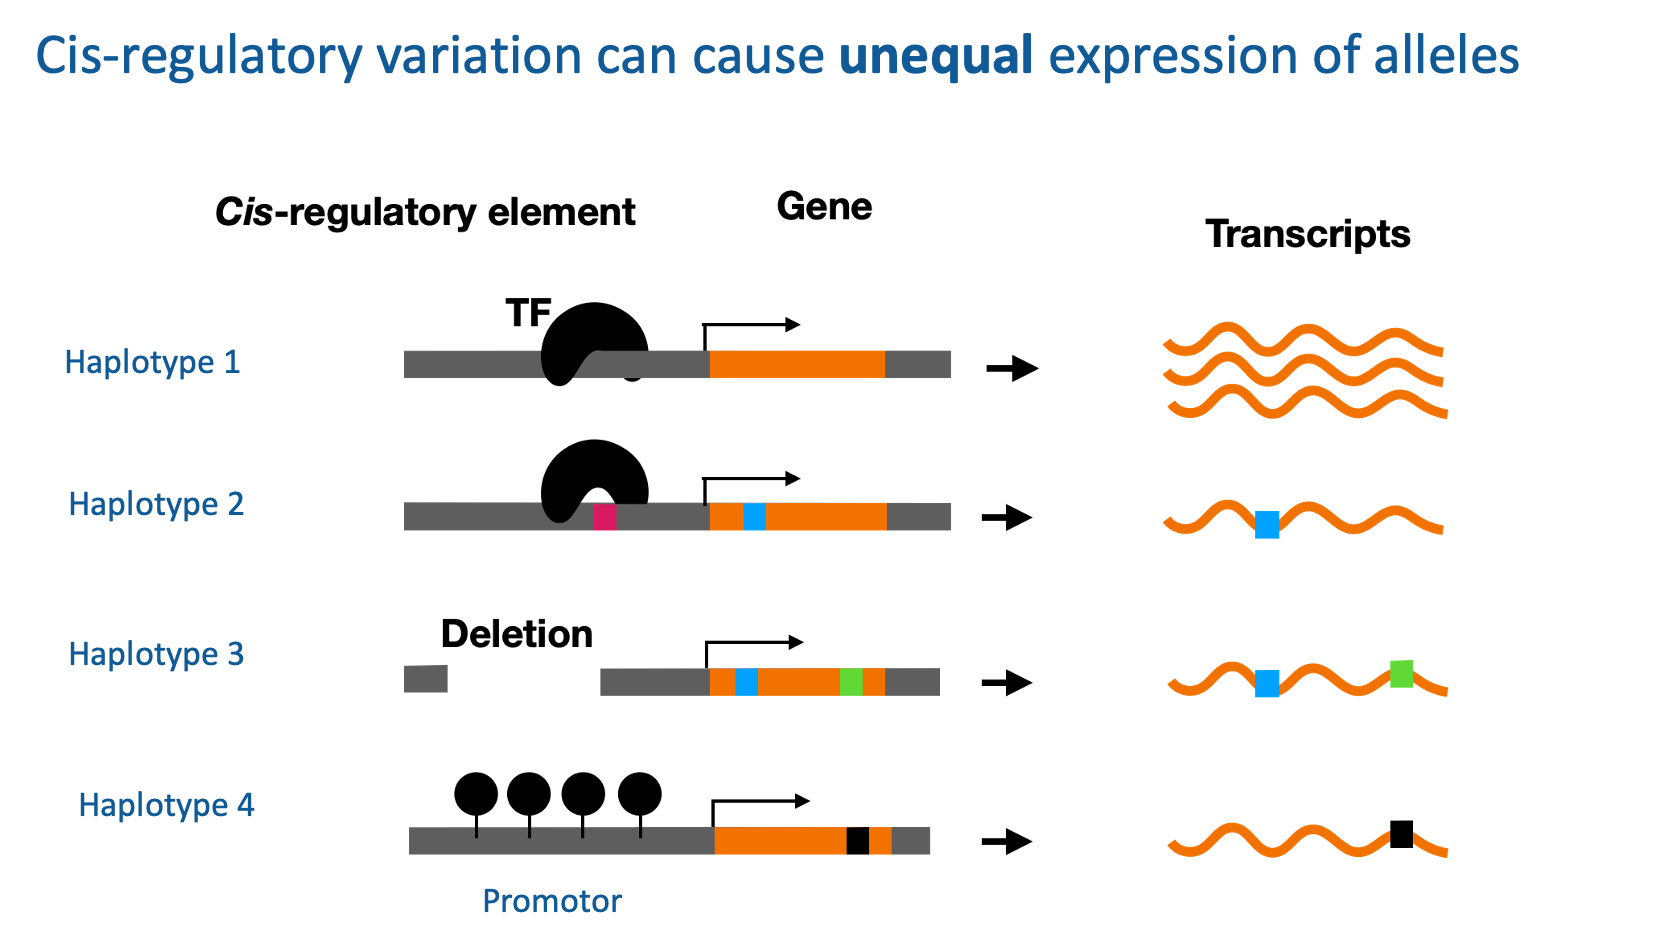

In [ ]:
# Select only the genes with 
# 1) equal lengths, 
# 2) low multimapping ratio and 
# 3) synteny category "1hap1_1hap2_1hap3_1hap4_s"
mask = (allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths" ) \
     & (allelic_data.var["multimapping_ratio"] < 0.25) \
     & (allelic_data.var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")

allelic_data_length_filter = allelic_data[:,mask].copy()

# Test for differential allelic ratios withing conditions
results = test_allelic_ratios_within_conditions(allelic_data_length_filter, layer="unique_counts", test_condition= "leaf", inplace=True)

# Plot the results
fig = plot_top_differential_syntelogs(results,n = 7, figsize=(1*3, 6*2), sort_by='ratio_difference') #, , difference_threshold=0.05)

The Alleles with a red title have some signigicant change in the allelic ratio. Not all alleles have equal expression

Lets look at the gene with "Synt_id_17123" in more detail:

In [ ]:
results[results["Synt_id"] == "Synt_id_17123"]

The column "ratio_difference" is the difference between our mean allele ratio and the expected ratio (0.25)

Lets look at the expression for these alleles of one sample in the genome Browser https://spuddb.uga.edu/jb2/?session=share-y51Gk46x4-&password=RWDWO. Does it really look like that allele 2 has higher expression than the other alleles?

#### Expand if JBRowse does not work

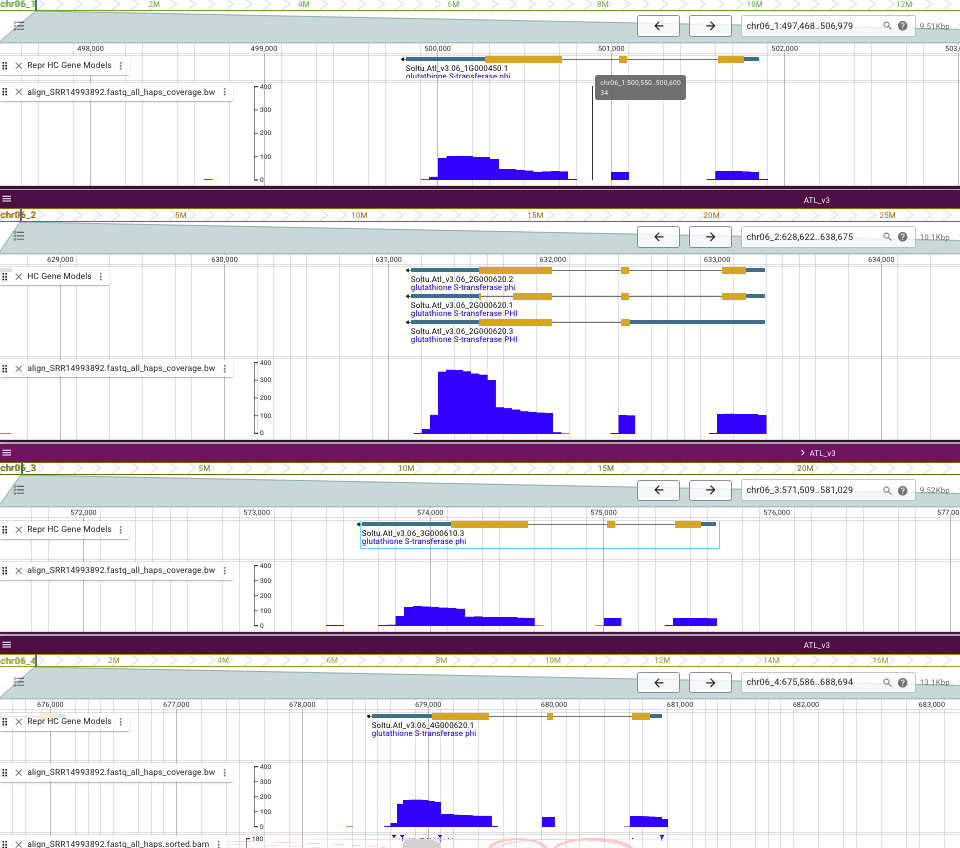

### Cis reulatory differences: Promotor analysis

Why is the allele 2 of gluthadione S-transferase higher expressed than the other alleles?

The differntial expression should be explained by cis-regulatory differences between the allles (if we can exlude any bias in due to technical artifacts), e.g:
* differences in methylation
* different transcription factor binging sites in the promotor


Since we can easily look at the promotors in our phased assembly, we check if there are any major differences.
We did a mulitple sequence alignment of the promotor regions (3000 bp upstream of start codon) with [DigAlign](
https://www.genome.jp/digalign/u/Nh0fqnx91m8IIspreJ9H6Q/aln/promoter_Soltu.Atl_v3.06_1G000/promoter_Soltu.Atl_v3.06_2G000/promoter_Soltu.Atl_v3.06_3G000/promoter_Soltu.Atl_v3.06_4G000).

**Question**: What do you notice is the difference between the promotor of allele 2 and the other promotors?

### Answer

We look at the insertion of promotor of allele 2 in more detail:
What could this seuqence be? 
```
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Sample
promoter_Soltu.Atl_v3.06_1G000450.1	2538	svim_asm.INS.1	C	
CTACCACTTCTTTCCATTAGGTCATCTAGAAGGAAGTAGGCAATAATTTAAAATAATTCCAATTATATTTATGGCAAAA
CACAATTTCAATTTTCAAATATTTTTTTCACATTAAAATAGGACCAATTCTATTTAACCACCAACGTAGATGATGCAGC
AGATAAAGTTATTCCTTTTTAAACCAAAAATCTCAAATTTGAATTAATATAAATTCAAAATAACAAGCTATATTTCTAG
CTCCAATACAAACACCAAATAATTTATTTTTTAAAAAATAATATAATTCTACTCTCAATAAATGTAAAAAGAACTTTCA
ACTATATCACCGCACATGTTGGACAAATACATGTTCCACT	.	PASS	
SVTYPE=INS;END=2538;SVLEN=355;READS=promoter_Soltu.Atl_v3.06_2G000620.2	GT	1/1
promoter_Soltu.Atl_v3.06_3G000610.3	2538	svim_asm.INS.1	C	
CTACCACTTCTTTCCATTAGGTCATCTAGAAGGAAGTAGGCAATAATTTAAAATAATTCCAATTATATTTATGGCAAAA
CACAATTTCAATTTTCAAATATTTTTTTCACATTAAAATAGGACCAATTCTATTTAACCACCAACGTAGATGATGCAGC
AGATAAAGTTATTCCTTTTTAAACCAAAAATCTCAAATTTGAATTAATATAAATTCAAAATAACAAGCTATATTTCTAG
CTCCAATACAAACACCAAATAATTTATTTTTTAAAAAATAATATAATTCTACTCTCAATAAATGTAAAAAGAACTTTCA
ACTATATCACCGCACATGTTGGACAAATACATGTTCCACT	.	PASS	
SVTYPE=INS;END=2538;SVLEN=355;READS=promoter_Soltu.Atl_v3.06_2G000620.2	GT	1/1
promoter_Soltu.Atl_v3.06_4G000620.1	2378	svim_asm.INS.1	T	
TTCCCTCGTATAAGACCTTATACGGTGTAGTCTAGCTCCAATACAAACACCAAATGAATTTTTTATTTTTAAATAATAT
AATTCTACTCTCAATAAATGTAAGAAGAACTTTCAACTATATCACCACACATGTTGGACAAAGACATGTTCCACCTACC
ACTTCTTTCCATTAGGTCATCTAGAAGGAAGTAGGCAATAATTTAAAATAATTCCAATTATATTTATGGCAAAACACAA
TTTCAATTTTCAAATATTTTTTTCACATTAAAATAGGACCAATTCTATTTAACCACCAACGTAGATGATGCAGCAGATA
AAGTTATTCCTTTTTAAACCAAAAATCTCAAATTTGAATTAATATAAATTCAAAATAACAAGCTATATTTCTAG	.	PASS	
SVTYPE=INS;END=2378;SVLEN=389;READS=promoter_Soltu.Atl_v3.06_2G000620.2	GT	1/1"
```


Maybe a transposable element, as it has many repeats. But further investiagtion is needed

#### Expand here if the link does not work



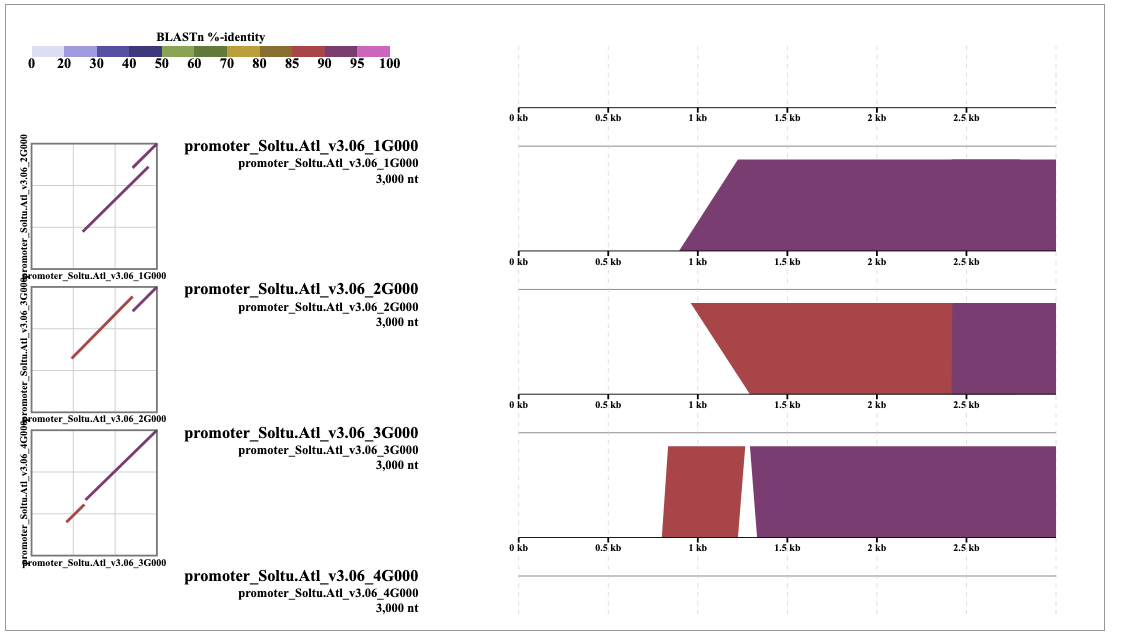





# 4) Testing for differential allele usage between tuber and leave

Now we can also test if between the two conditions (tuber and leaf) the allelic expression changes. E.g is there a dominant allele in tuber that is not expressed in leaf? We use the same test as before (likelyhood-ratio). But this time we compare counts for allele 1 of leaf vs counts of allele 2 (and so on..) of tuber.

In [ ]:
# Filter to only include synteny category "1hap1_1hap2_1hap3_1hap4_s" 
mask = (allelic_data.var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")
allelic_data_group_filter = allelic_data[:,mask].copy()

**Question**: Why are we not filtering the alleles with high multimapping ratios or unqual lengths?

#### Answer

As we are now comparing each allele biases from errors in the reference are present in both conditions so should not lead to wrong results. If we compare alleles of a gene, differences in annotation can bias the results.

#### Testing

In [ ]:
# Test for each allele
results_trans = test_allelic_ratios_between_conditions(allelic_data_group_filter)

#  Plot the results
fig = plot_top_differential_syntelogs(results_trans, figsize=(3*1, 2*5), sort_by='FDR' )


In [ ]:
results_trans[results_trans["Synt_id"] == "Synt_id_31641"]

Which allele has the biggest difference between tuber and leaf? Look also in jBrowse at the data

Lets look again in more detail at one of the genes in the [jBrowse](https://spuddb.uga.edu/jb2/?session=local-7vzorxQDd9kfw8i1oFRMz) and open one bigwig from tuber and one from leaf.




#### Expand if jBrowse does not work (or if you are lazy)

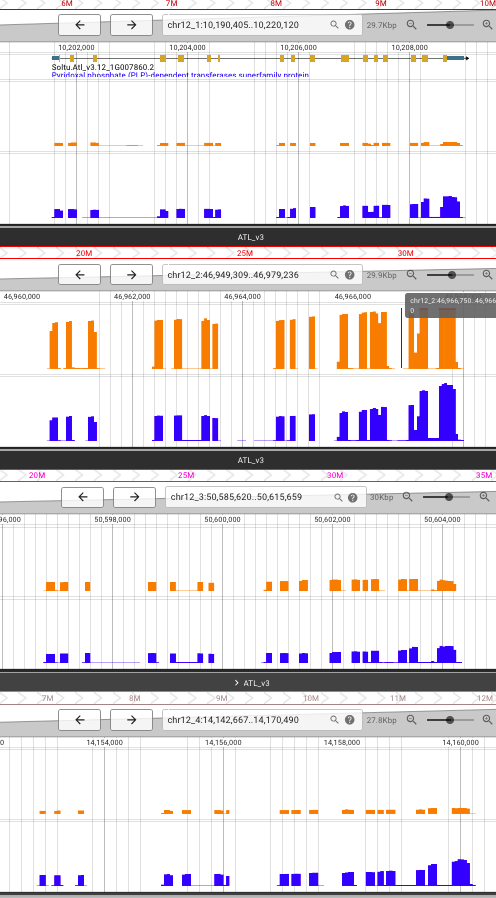


**Question**: What are the biological mechanisms between the change in allelic expression between conditions?

#### Answer


The differences between allelic expression could come from the presence of different transcription facotors (TFs). In our example there are probably TFs that are only present in tuber or in leave.

### Congratulations! 🎉

You finished the allele-specific expression practical! 

#### What to do with remaining time:

- **Experiment with parameters:** Adjust filtering thresholds and explore how they affect your results
- **Explore interesting genes:** Look for other genes showing allele-specific expression patterns
- **Ask questions:** Clarify any concepts or methods you'd like to understand better
- **Help a fellow student:** Share your knowledge and learn from others' perspectives

Great work completing this analysis!

### Resources and Code

**All pipleines under active development**

1) Grouping of genes in phased assemblies to alleles [nextflow pipeline](https://github.com/NIB-SI/potato-allelic-orthogroups/tree/main)

2) How to get allele specific counts [nextflow pipeline](https://github.com/nadjano/longrnaseq)


3) Allele specific expression analysis: 
[Polyase package](https://test.pypi.org/project/polyase/)
